In [179]:
import json
import numpy as np
import scipy.sparse as sparse
from os import listdir
import matplotlib.pyplot as plt

In [180]:
deletion_file = '../deletions_to_validate/platinum.json'
data_dir = '../split_gen_platinum'

In [181]:
with open(deletion_file, 'r') as f:
    deletions = json.load(f)


In [244]:
deletion_index = 4
deletion = deletions[deletion_index]
fr_left, fr_right = 15, 15

In [245]:
individuals = [deletion['mother'], deletion['father']] + deletion['trans'] + deletion['notrans']
chrom = deletion['chrom']
start_pos = deletion['start_pos']
end_pos = deletion['end_pos']
print('%s:%d-%d' % (chrom, start_pos, end_pos))

2:53165520-53170718


In [246]:
# read samples
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_id_to_index = dict([(line.strip(), i) for i, line in enumerate(f)])
family_indices = np.array([sample_id_to_index[x] for x in individuals])
    
# load genotypes
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)
is_pass = pos_data[:, 3].astype(bool)
is_in_region = (snp_positions >= start_pos) & (snp_positions <= end_pos)
start_index = np.where(~is_in_region[:-1] & is_in_region[1:])[0][0]+1
end_index = np.where(is_in_region[:-1] & ~is_in_region[1:])[0][0]
is_in_region[start_index-fr_left:start_index] = True
is_in_region[end_index:end_index+fr_right] = True

print('Sites pulled from vcf:', snp_positions.shape[0])

# Pull data together
#A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[family_indices, :] for gen_file in gen_files])
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])

# only look at snps that PASS GATK filter
A = A[:, is_snp & is_pass & is_in_region]
snp_positions = snp_positions[is_snp & is_pass & is_in_region]

# sparse to dense
A = A.A

Sites pulled from vcf: 423601


In [247]:
indices = np.any(A[:, 1:] != A[:, :-1], axis=0).tolist() + [True]
print(np.sum(indices))
print(((snp_positions >= start_pos) & (snp_positions <= end_pos))[:, np.newaxis].shape)


14
(33, 1)


In [248]:
family_has_deletion = np.zeros((3, snp_positions.shape[0]))
with open('../deletions_ihart/chr.%s.deletions.json' % chrom, 'r') as f:
    all_deletions = json.load(f)
    for d in all_deletions:
        if deletion['family'] == d['family'] and np.sum((snp_positions >= d['start_pos']) & (snp_positions <= d['end_pos'])):
            print(d)
            if d['is_mat'] and not d['is_denovo']:
                family_has_deletion[0, (snp_positions >= d['start_pos']) & (snp_positions <= d['end_pos'])] += 1
            elif d['is_pat'] and not d['is_denovo']:
                family_has_deletion[1, (snp_positions >= d['start_pos']) & (snp_positions <= d['end_pos'])] += 1
            elif d['is_denovo']:
                family_has_deletion[2, (snp_positions >= d['start_pos']) & (snp_positions <= d['end_pos'])] += 1

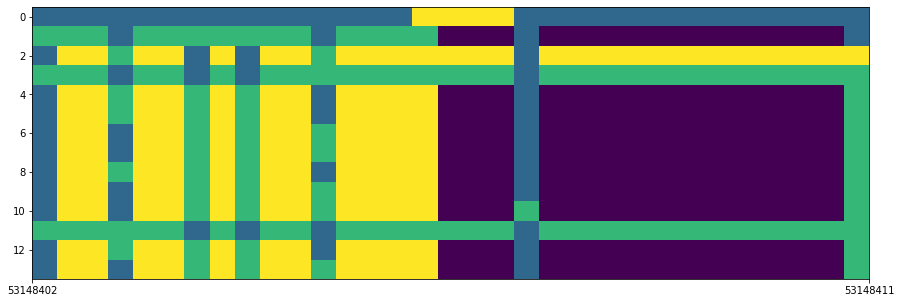

In [249]:
plt.figure(figsize=(15, 5))
indices = np.any(A[:, 1:] != A[:, :-1], axis=0).tolist() + [True]
plt.imshow(np.vstack((2*((snp_positions >= start_pos) & (snp_positions <= end_pos))[np.newaxis, :], A)), 
           aspect='auto', vmin=-1, vmax=2)
plt.xticks(plt.xlim(), [snp_positions[0], snp_positions[1]])
plt.show()

In [96]:
print('is_mat?', deletion['is_mat'], '\ntransmitted to %d children' % len(deletion['trans']))

is_mat? True 
transmitted to 2 children
